In [2]:
import torch
import csv   
import datetime
import math

import torch.nn as nn 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter
from random import randint

from GANutils import *
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

## Initialise the device
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [ ]:
### The following implememnation is based on the TensorFlow WGAN implementation for the Population Synthesis (see Example)
### the implementation was inspired by the following github repositories: 
## https://github.com/martinarjovsky/WassersteinGAN
## https://github.com/shyam671/Multi-Agent-Diverse-Generative-Adversarial-Networks/blob/master/Mad_GANs.ipynb
## https://github.com/shaabhishek/gumbel-softmax-pytorch/blob/master/Gumbel-softmax%20visualization.ipynb

In [3]:
data = pd.read_pickle('Data/TU_onehot')
data = back_from_dummies(data)
data = data.drop(['HomeAdrMunCode'], axis=1)
data = encode_onehot(data)
clear_output()

In [4]:
cat = Counter([v.split('_')[0] for v in list(data.columns)])
cat_total = sum(cat.values())
cat_n = list(cat.values())
INPUT_SIZE = 100
TARGET_NUM = len(data.columns)
GUMBEL_EPS = 1E-20
NUM_GEN = 3
print(INPUT_SIZE, TARGET_NUM)

100 301


In [5]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]), requires_grad=False)
    return n

In [6]:
def sample_gumbel(shape, eps=GUMBEL_EPS):
    unif = torch.rand(*shape).to(device)
    g = -torch.log(-torch.log(unif + eps))
    return g.to(device)

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape)
    h = (g + logits)/temperature.to(device)
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [7]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 temperature: float,
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        self.temperature = torch.Tensor([temperature]).to(device)
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size * 2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential( 
            nn.Linear(hidden_size * 2, self.output_size))
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Softmax per class
        x = (x.split(self.cat_n, dim=1))
        out = torch.cat([sample_gumbel_softmax(v, temperature = self.temperature) for v in x], dim=1)
        return out


In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size:int):
        '''
        input_size: size of the data
        output_size: is always 1 
        vanila: if True, Sigmoid is going to applied on the last layer
        '''
        super(Discriminator,self).__init__()
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, NUM_GEN+1),
            torch.nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.out(x)
        return x

In [12]:
class MADGAN():
    def __init__(self, 
                 data, 
                 cat, 
                 epochs = 1000,
                 batch_size=64,  #64         
                 gen_learn_rate=1E-5, # 4   
                 disc_learn_rate=1E-5, # 5
                 temperature = 1E-3,
                 gen_hidden_size = 512): 
        #Data
        self.cat = cat
        self.cat_n = list(cat.values())
        self.onehot_size = sum(self.cat.values())
        self.train_val_split(data, batch_size)
        
        #Networks
        self.G = []
        for i in range(NUM_GEN):
            self.G.append(Generator(input_size=INPUT_SIZE, hidden_size=gen_hidden_size,  
                           temperature=temperature, cat=self.cat).to(device))
        self.D = Discriminator(input_size=TARGET_NUM).to(device)
        

        
        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.gen_learn_rate = gen_learn_rate
        self.gen_hidden_size = gen_hidden_size
        self.disc_learn_rate = disc_learn_rate
        self.temperature = temperature 
        self.loss = nn.NLLLoss()

        '''
        self.generator_optim = []
        for i in range(NUM_GEN):
            self.generator_optim.append(torch.optim.Adam(self.G[i].parameters(), gen_learn_rate, betas=(0.5, 0.999)))
            
        self.discriminator_optim = torch.optim.Adam(self.D.parameters(), disc_learn_rate, betas=(0.5, 0.999))
    
        '''
        self.generator_optim = []
        for i in range(NUM_GEN):
            self.generator_optim.append(torch.optim.RMSprop(self.G[i].parameters(),
                                                  lr = self.gen_learn_rate,
                                                  centered=True))
        self.discriminator_optim = torch.optim.RMSprop(self.D.parameters(),
                                                      lr = self.disc_learn_rate,
                                            centered=True)
    
    
    def train_val_split(self, data, batch_size):
        train, val = train_test_split(data, test_size=0.3)
        self.train = DataLoader(torch.tensor(train.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
        self.val  = DataLoader(torch.tensor(val.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=4)
    def sample(self, i_gen: int, n_samples: int):
        '''
        Generate the data data with Generator network
        n_samples: usually equals to the batch size
        '''
        z = gen_noise(INPUT_SIZE, n_samples)
        z = Variable(z, requires_grad=False).to(device)
        return self.G[i_gen].forward(z)

    def reset_gradient(self):
        self.D.zero_grad()
        for i in range(NUM_GEN):
            self.G[i].zero_grad()
        
        
    def fit(self, n_critic=1, n_gen=NUM_GEN, to_log=True):
        filename = 'Logs/madgan-{date:%Y-%m-%d_%H:%M:%S}'.format( date=datetime.datetime.now() )
        filename = filename.replace(':', '')
        self.log_setting(filename, n_critic)
        self.discriminator_loss, self.generator_loss = [], []
        for epoch in range(self.epochs):
            gen_gradient = 0
            batch_d_loss, batch_g_loss = [], []
            batch_g_loss_single = [[], [], []]
            batch_val = []
            
            #### check the weight of each generator 
            a=[]
            ad = list(self.D.parameters())[0].clone()
            for i in range(NUM_GEN):
                a.append(list(self.G[i].parameters())[0].clone())
        

    
            for x in self.train:
                ## Reset gradient for both networks (on new epoch)
                self.reset_gradient()
                x = Variable(x).float().to(device)
                
                ## Determine the batch size
                batch_size = x.shape[0]
                labelG = Variable(torch.LongTensor(batch_size))
                labelG = labelG.to(device)
                
                labelD = Variable(torch.LongTensor(batch_size))
                labelD = labelD.to(device)
                #STEP 1. TRAIN THE GENERATOR (if n_gen is larger than 1)
                #Total_G_loss = 0
                for i in range(NUM_GEN):
                    x_fake = self.sample(i, batch_size).to(device)
                    output = self.D.forward(x_fake)
                    
                    # Calculate the loss
                    G_loss = self.loss(output, labelG.fill_(NUM_GEN))
                    G_loss.backward()
                    self.generator_optim[i].step()
                    self.reset_gradient()
                    batch_g_loss.append(G_loss.item())
                    batch_g_loss_single[i].append(G_loss.item())

                # STEP 2. TRAIN THE DISCRIMINATOR (With gradient penalty)
                if n_critic <= 0: n_critic=1
                for _ in range(n_critic):
                    output_true = self.D.forward(x)
                    for i in range(NUM_GEN):
                        # Step 2.1 Generate fake data G(z), where z ~ N(0, 1)
                        x_fake = self.sample(i, batch_size).to(device)
                        # Step 3. Send fake data through discriminator
                        #         propagate error and update D weights.
                        # --------------------------------------------
                        # Note: detach() is used to avoid compounding generator gradients
                        output_fake = self.D.forward(x_fake.detach()) 
                    
                        D_loss_real = self.loss(output_true, labelD.fill_(NUM_GEN + 0.1*randint(-1,1)))
                        D_loss_fake = self.loss(output_fake, labelG.fill_(i + 0.1*randint(-1,1)))
                        D_loss = (D_loss_real + D_loss_fake)/2
                        if i<NUM_GEN-1:
                            D_loss.backward(retain_graph=True)
                        else:
                            D_loss.backward()

                        # Calulate and update gradients of discriminator
                        self.discriminator_optim.step()
                        self.reset_gradient()
                        batch_d_loss.append(D_loss.item())
                                
            
            self.discriminator_loss.append(np.mean(batch_d_loss))
            self.generator_loss.append(np.mean(batch_g_loss))   
            b=[]
            for i in range(NUM_GEN):
                b.append(list(self.G[i].parameters())[0].clone())
            bd = list(self.D.parameters())[0].clone()
                
            clear_output()
            print("Epoch: %3d || D Loss: %5.5f || G Loss: %5.5f " %(epoch, np.mean(batch_d_loss), 
                                                                               np.mean(batch_g_loss)))

            # -- Plotting --
            f, axarr = plt.subplots(1, 2, figsize=(18, 7))

            # Loss
            axarr[0].set_xlabel('Epoch')
            axarr[0].set_ylabel('Loss')
            axarr[0].set_title('Discriminator Loss || lr= %s' %self.disc_learn_rate )
            axarr[1].set_xlabel('Epoch')
            axarr[1].set_ylabel('Loss')
            axarr[1].set_title('Generator Loss  || lr= %s' %self.gen_learn_rate )
            axarr[0].plot(np.arange(epoch+1), self.discriminator_loss)
            axarr[1].plot(np.arange(epoch+1), self.generator_loss, linestyle="--", linewidth=1.5)
            plt.show()
            
            for i in range(NUM_GEN):
                print('GENERATOR %s is updated: %s' %(i,  not torch.equal(a[i].data, b[i].data)))
            print('DISCRIMINATOR is updated: %s' %(not torch.equal(ad.data, bd.data)))
            
            if to_log:
                self.log(filename, epoch, np.mean(batch_d_loss), np.mean(batch_g_loss), 
                         np.mean(batch_g_loss_single[0]),
                         np.mean(batch_g_loss_single[1]),
                         np.mean(batch_g_loss_single[2])
                        )
    

    def log(self, name, epoch, d_loss, g_loss, g0, g1, g2):
        fields=[epoch, d_loss, g_loss, g0, g1, g2]
        with open(r''+name + '.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(fields)
        if (epoch % 50 == 0) or (epoch==0):
            for i in range(NUM_GEN):
                torch.save(self.G[i], name+'G'+ str(i))
            torch.save(self.D, name+'D')
    def log_setting(self, name, n_critic):
        with open(r''+name+ '.txt', 'w') as f:
            f.write('BATCH NUM:  %s \n' %self.batch_size)
            f.write('Latent Space %s \n' %INPUT_SIZE)
            f.write('Target Num %s \n'%TARGET_NUM)
            f.write('D_LR %s \n' %self.disc_learn_rate)
            f.write('G_LR %s \n'%self.gen_learn_rate)
            f.write('Softmax T %s \n' %self.temperature)       
            f.write('G_hidden_size %s \n' %self.gen_hidden_size,)  
            f.write('G NUM %s \n' %NUM_GEN)  
            f.write('C/D NUM %s \n' %n_critic)  
            f.close()

            

In [13]:
gan = MADGAN(data = data, cat = cat)

Epoch: 107 || D Loss: 0.65984 || G Loss: 4.40484 


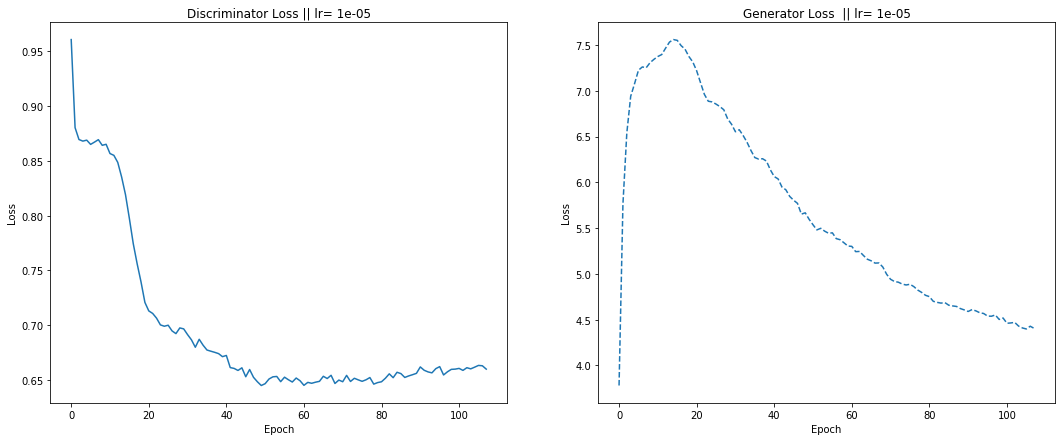

GENERATOR 0 is updated: True
GENERATOR 1 is updated: True
GENERATOR 2 is updated: True
DISCRIMINATOR is updated: True


In [ ]:
gan.fit(n_critic=1) ##add num of critics